***
*Project:* Helmholtz Machine

*Author:* Jingwei Liu, Computer Music Ph.D., UC San Diego
***

# <span style="background-color:darkorange; color:white; padding:2px 6px">Document Main 1</span> 

# Vanilla Helmholtz Machine


*Updated:* Nov 29, 2024


<img src="Helmzz.jpg" style="width:550px">
<caption><center> **Figure 4**: The Helmholtz Machine  </center></caption>

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import torch
torch.cuda.is_available()

True

In [9]:
dev = torch.device("cpu") # operate on GPU "cuda" or CPU "cpu"

In [10]:
structure = [10,8,6,3,1]
n_dz = torch.tensor(structure,device=dev)
n_dz

tensor([10,  8,  6,  3,  1])

In [11]:
n_dz.shape

torch.Size([5])

$$p_n^m(\theta, s^{m+1}) = \sigma(\sum_k \theta_{k,n}^{m+1,m} \centerdot s_k^{m+1})$$
$$q_n^m(\phi, s^{m-1}) = \sigma(\sum_k \phi_{k,n}^{m-1,m} \centerdot s_k^{m-1})$$

In [12]:
def para_init(n_dz):
    """
    Arguments:
    n_dz -- torch tensor of size len(n_dz)
    init_type -- "zero"

    Returns:
    Phi, Theta -- set of parameters for hierarchical layers
    """
    Phi = {}
    Theta = {}
    l = len(n_dz)
    for i in range(l-2):
        Phi["Phi_" + str(i) + str(i+1)] = torch.zeros((n_dz[i+1],n_dz[i]),device=dev)
    for i in range(l-1,0,-1):
        Theta["Theta_" + str(i) + str(i-1)] = torch.zeros((n_dz[i-1],n_dz[i]),device=dev)
    return Phi,Theta

In [7]:
Phi,Theta = para_init(n_dz)

In [8]:
Phi['Phi_01'].shape[1]

10

In [13]:
def sigmoid(x):
    """
    Arguments:
    x -- torch tensor of shape (n,batch_size)
    
    Returns:
    p -- probability of layer y, torch tensor of shape (n,batch_size)
    """
    p = 1/(1+torch.exp(-x))
    return p

In [14]:
def one_step_forward(x,param):
    """
    Arguments:
    x -- input layer, torch tensor of shape (n_x,batch_size)
    param -- parameters from x to y. Torch tensor of shape (n_y,n_x)
    
    Returns:
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    """
    q = sigmoid(torch.matmul(param,x.type(torch.float)))
    return q

In [15]:
def sample(q):
    """
    Arguments:
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    
    Returns:
    y -- instantiation of layer y, torch tensor of shape (n_y,batch_size)
    """
    y = (q > torch.rand(q.size())).long() # rejection sampling
    return y

#### Local delta rule

$$
\begin{align}
\frac{\partial L}{\partial \theta_{j,i}}
&= (q_j - y_j)x_i \\
&=  \left \{
\begin{array}{ll}
(q_j - 1)x_i & \text{if } y_j = 1 \\
q_j \centerdot x_i & \text{if } y_j = 0
\end{array} \right.
\end{align}
$$

By gradient descent,
$$\theta = \theta - lr \centerdot \frac{\partial L}{\partial \theta}$$

In [16]:
def cross_entropy_loss(y,q):
    """
    Arguments:
    y -- output layer sample, torch tensor of shape (n_y,batch_size)
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    
    Returns:
    loss -- cross entropy loss, L = (-y.*log(q)).mean()
    """
    loss = (-y * torch.where(q != 0, torch.log(q), -10)).mean()
    return loss

In [17]:
def one_step_update(x,y,param,lr):
    """
    Arguments:
    x -- input layer sample, torch tensor of shape (n_x,batch_size)
    y -- output layer sample, torch tensor of shape (n_y,batch_size)
    param -- parameters from x to y. Torch tensor of shape (n_y,n_x)
    lr -- learning rate
    
    Returns:
    grad -- gradient of parameters. Torch tensor of shape (n_y,n_x)
    param -- updated parameters from x to y. Torch tensor of shape (n_y,n_x)
    loss -- cross entropy loss, L = (-y.*log(q)).mean()
    """
    batch_size = x.shape[1]
    q = one_step_forward(x,param)
    grad = torch.matmul(q-y,torch.t(x.type(torch.float)))/batch_size # weight by precision
    param = param - lr*grad
    loss = cross_entropy_loss(y,q)
    return param, grad, loss

In [18]:
def layer_wise_train(input_x,param_xy,param_yx,lr):
    """
    Arguments:
    input_x -- input layer sample, torch tensor of shape (n_x,batch_size)
    param_xy -- parameters from x to y. Torch tensor of shape (n_y,n_x)
    param_yx -- parameters from y to x. Torch tensor of shape (n_x,n_y)
    lr -- learning rate
    
    Returns:
    output_y -- output layer sample, torch tensor of shape (n_y,batch_size)
    param_yx -- updated parameters from y to x
    grad -- gradient of param_yx. Torch tensor of shape (n_x,n_y)
    loss -- cross entropy loss at layer x
    """
    # Compute output layer distribution
    q = one_step_forward(input_x,param_xy)
    
    # Sample the output layer
    output_y = sample(q)
    
    # train the opposite phase from x to y
    param_yx, grad, loss = one_step_update(output_y,input_x,param_yx,lr)
    
    return output_y, param_yx, grad, loss

In [19]:
def wake_phase(Phi,Theta,data,lr,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    data -- input data. Torch tensor of shape (n_d,batch_size)
    lr -- learning rate
    dev -- torch device
    
    Returns:
    Theta -- updated sleep phase parameters.
    Grad -- set of gradients for Theta. len(Grad) = n_layer-1
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    Grad = {}
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    batch_size = data.shape[1]
    input_x = data
    for i in range(n_layer-2):
        output_y, Theta["Theta_" + str(i+1) + str(i)], Grad["Grad_" + str(i+1) + str(i)], Loss[i] = \
        layer_wise_train(input_x,Phi["Phi_" + str(i) + str(i+1)],Theta["Theta_" + str(i+1) + str(i)],lr)
        input_x = output_y
    Theta["Theta_" + str(n_layer-1) + str(n_layer-2)], Grad["Grad_" + str(n_layer-1) + str(n_layer-2)], Loss[n_layer-2] = \
    one_step_update(torch.ones(1,batch_size,dtype=int,device=dev),input_x,Theta["Theta_" + str(n_layer-1) + str(n_layer-2)],lr)
    return Theta, Grad, Loss

In [20]:
def sleep_phase(Phi,Theta,gen_batch_size,lr,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    gen_batch_size -- number of generated samples in a batch
    lr -- learning rate
    dev -- torch device
    
    Returns:
    Phi -- updated sleep phase parameters.
    Grad -- set of gradients for Phi. len(Grad) = n_layer-2
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    Grad = {}
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    unit = torch.ones(1,gen_batch_size,dtype=int,device=dev)
    input_x = sample(one_step_forward(unit,Theta["Theta_" + str(n_layer-1) + str(n_layer-2)]))
    for i in range(n_layer-2,0,-1):
        output_y, Phi["Phi_" + str(i-1) + str(i)], Grad["Grad_" + str(i-1) + str(i)], Loss[i] = \
        layer_wise_train(input_x,Theta["Theta_" + str(i) + str(i-1)],Phi["Phi_" + str(i-1) + str(i)],lr)
        input_x = output_y
    return Phi, Grad, Loss

In [21]:
def one_step_prob_matrix(n_x, param,dev):
    """
    Arguments:
    n_x -- number of neurons at input layer x
    param -- parameters from layer x to y. Torch tensor of shape (n_y,n_x)
    dev -- torch device
    
    Returns:
    prob_ft -- factorial probability. Torch tensor of shape (2**n_x, n_y).
    prob_ct -- categorical probability. Torch tensor of shape (2**n_x, 2**n_y)
    """
    X = binarilize(np.arange(2**n_x),n_x,dev)  # (n_x,2**n_x)
    q = one_step_forward(X,param)   # (n_y,2**n_x)
    prob_ft = torch.t(q)  # (2**n_x,n_y)
    
    # categorical probability
    n_y = q.shape[0]
    Y = binarilize(np.arange(2**n_y),n_y,dev)  # (n_y,2**n_y)
    prob_ct = torch.zeros(2**n_x, 2**n_y,device=dev)
    for i in range(2**n_x):
        prob_ct[i,:] = torch.prod(q[:,i:i+1]**Y * (1-q[:,i:i+1])**(1-Y),axis=0)
    
    # Ursatz = 1
    if n_x == 1:
        prob_ft = prob_ft[1:,:]
        prob_ct = prob_ct[1:,:]
    return prob_ft, prob_ct

In [78]:
def entropy(row_dist):
    """
    Arguments: row_dist -- unnormalized row distribution. Torch tensor of shape (n_row, n_p) or (n_p,)
    Returns: H -- row entropy. Torch tensor of shape (n_row,1) or a number
    """
    if row_dist.ndim == 1:
        p = row_dist/row_dist.sum()
        H = (-p * torch.where(p != 0, torch.log(p), -10)).sum()
    else:
        P = row_dist/row_dist.sum(axis=1,keepdims=True)
        H = (-P * torch.where(P != 0, torch.log(P), -10)).sum(axis=1,keepdims=True)
    return H

In [85]:
def entropy_bernoulli(P_ber):
    """
    Arguments: P_ber -- multi-variate independent row Bernoulli distributions. Torch tensor of shape (n_row, n_p) or (n_p,)
    Returns: H_ber -- row Bernoulli entropy. Torch tensor of shape (n_row,1) or a number
    """
    entropy = - (P_ber*torch.where(P_ber!=0,torch.log(P_ber),-10)+(1-P_ber)*torch.where((1-P_ber)!=0,torch.log(1-P_ber),-10))
    if P_ber.ndim == 1:
        H_ber = entropy.sum()
    else:
        H_ber = entropy.sum(axis=1,keepdims=True)
    return H_ber

In [98]:
def prob_matrix_ct(dist_ct_pre, prob_ct):
    """
    Arguments:
    dist_ct_pre -- prior of input layer distribution. Torch tensor of shape (n_prior,2**n_x), n_prior = 1 usually
    prob_ct -- categorical probability. Torch tensor of shape (2**n_x, 2**n_y). x,y don't have to be adjacent layers
    note: x,y don't have to be adjacent layers. E.g. n_x = 3, n_y = 10
    
    Returns:
    dist_ct -- categorical distribution at output layer y. Torch tensor of shape (n_prior,2**n_y), n_prior = 1 usually
    H_ct_Y -- categorical entropy of output layer y. Torch tensor of shape (n_prior,1). H_ct_Y != H_ft_Y
    H_ct_YX -- conditional categorical entropy H(Y|X). Torch tensor of shape (n_prior,1). H_ct_YX = H_ft_YX
    """
    dist_ct = torch.matmul(dist_ct_pre,prob_ct)
    H_ct_Y = entropy(dist_ct)
    H_ct_YX = torch.matmul(dist_ct_pre,entropy(prob_ct))
    
    # I = H_Y - H_YX
    return dist_ct, H_ct_Y, H_ct_YX

In [99]:
def prob_matrix_ft(dist_ct_pre, prob_ft):
    """
    Arguments:
    dist_ct_pre -- prior of input layer distribution. Torch tensor of shape (n_prior,2**n_x), n_prior = 1 usually
    prob_ft -- factorial probability. Torch tensor of shape (2**n_x, n_y). x,y don't have to be adjacent layers
    note: x,y don't have to be adjacent layers. E.g. n_x = 3, n_y = 10
    
    Returns:
    dist_ft -- factorial distribution at output layer y. Torch tensor of shape (n_prior,n_y), n_prior = 1 usually
    H_ft_Y -- factorial entropy of output layer y. Torch tensor of shape (n_prior,1). H_ct_Y != H_ft_Y
    H_ft_YX -- conditional factorial entropy H(Y|X). Torch tensor of shape (n_prior,1). H_ct_YX = H_ft_YX
    """
    dist_ft = torch.matmul(dist_ct_pre,prob_ft)
    H_ft_Y = entropy_bernoulli(dist_ft)
    H_ft_YX = torch.matmul(dist_ct_pre,entropy_bernoulli(prob_ft))
    
    # I = H_Y - H_YX
    return dist_ft, H_ft_Y, H_ft_YX

In [70]:
n_x = 5
binarilize(np.arange(2**n_x),n_x,dev)

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
         1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
         0, 0, 0, 0, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1,
         0, 0, 1, 1, 0, 0, 1, 1],
        [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
         0, 1, 0, 1, 0, 1, 0, 1]])

In [71]:
n_y = 3
Y = binarilize(np.arange(2**n_y),n_y,dev)
Y

tensor([[0, 0, 0, 0, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 0, 1, 1],
        [0, 1, 0, 1, 0, 1, 0, 1]])

In [72]:
torch.rand((n_y))/torch.rand((n_y)).sum()

tensor([0.4244, 0.5242, 0.3152])

In [73]:
q = torch.rand((n_y,2**n_x))
q

tensor([[0.8416, 0.4807, 0.8992, 0.6907, 0.8803, 0.2740, 0.8489, 0.6732, 0.1607,
         0.4205, 0.7208, 0.7227, 0.5051, 0.5911, 0.4387, 0.6886, 0.9464, 0.4692,
         0.0272, 0.1554, 0.7101, 0.6975, 0.5761, 0.0896, 0.3763, 0.6626, 0.0765,
         0.7804, 0.0336, 0.1474, 0.4873, 0.2584],
        [0.5675, 0.5636, 0.7748, 0.4145, 0.2759, 0.4831, 0.3914, 0.4795, 0.3876,
         0.5815, 0.2179, 0.3726, 0.1056, 0.6515, 0.5323, 0.6340, 0.8186, 0.8479,
         0.3113, 0.5319, 0.4089, 0.5751, 0.6127, 0.4868, 0.5761, 0.9758, 0.2721,
         0.6264, 0.0118, 0.7294, 0.7094, 0.6642],
        [0.2158, 0.3112, 0.1581, 0.6030, 0.5461, 0.5972, 0.8094, 0.6325, 0.2491,
         0.8322, 0.1712, 0.3543, 0.1245, 0.2733, 0.7955, 0.5113, 0.9686, 0.7175,
         0.9665, 0.7898, 0.1576, 0.6700, 0.3959, 0.0579, 0.8801, 0.7956, 0.7640,
         0.4780, 0.0037, 0.8757, 0.1326, 0.5960]])

In [75]:
torch.where(q != 0, torch.log(q), -10)

tensor([[-0.1725, -0.7324, -0.1063, -0.3700, -0.1275, -1.2946, -0.1638, -0.3958,
         -1.8279, -0.8663, -0.3274, -0.3248, -0.6831, -0.5258, -0.8239, -0.3732,
         -0.0551, -0.7567, -3.6027, -1.8620, -0.3424, -0.3603, -0.5515, -2.4120,
         -0.9773, -0.4117, -2.5708, -0.2479, -3.3938, -1.9143, -0.7190, -1.3533],
        [-0.5665, -0.5734, -0.2551, -0.8806, -1.2875, -0.7276, -0.9381, -0.7351,
         -0.9478, -0.5421, -1.5237, -0.9873, -2.2480, -0.4285, -0.6306, -0.4557,
         -0.2002, -0.1650, -1.1669, -0.6313, -0.8944, -0.5532, -0.4899, -0.7200,
         -0.5515, -0.0245, -1.3014, -0.4678, -4.4436, -0.3155, -0.3433, -0.4092],
        [-1.5335, -1.1674, -1.8443, -0.5058, -0.6049, -0.5155, -0.2114, -0.4581,
         -1.3899, -0.1837, -1.7650, -1.0375, -2.0833, -1.2973, -0.2288, -0.6709,
         -0.0319, -0.3320, -0.0341, -0.2360, -1.8476, -0.4004, -0.9266, -2.8492,
         -0.1277, -0.2286, -0.2692, -0.7382, -5.5989, -0.1328, -2.0203, -0.5175]])

In [148]:
q[:,0:1]**Y

tensor([[1.0000, 1.0000, 1.0000, 1.0000, 0.7434, 0.7434, 0.7434, 0.7434],
        [1.0000, 1.0000, 0.9751, 0.9751, 1.0000, 1.0000, 0.9751, 0.9751],
        [1.0000, 0.9227, 1.0000, 0.9227, 1.0000, 0.9227, 1.0000, 0.9227]])

In [151]:
torch.prod(q[:,0:1]**Y * (1-q[:,0:1])**(1-Y),axis=0)

tensor([4.9390e-04, 5.8983e-03, 1.9332e-02, 2.3087e-01, 1.4310e-03, 1.7089e-02,
        5.6009e-02, 6.6888e-01])

In [81]:
torch.ones(1,batch_size,dtype=int,device=dev).shape

torch.Size([1, 256])

In [71]:
x = torch.rand((5,3)).long()
x

tensor([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]])

In [72]:
param = torch.rand((4,5))
param

tensor([[0.8166, 0.5580, 0.6784, 0.0909, 0.2673],
        [0.9881, 0.1565, 0.7359, 0.9514, 0.3198],
        [0.2172, 0.4402, 0.8490, 0.3588, 0.5684],
        [0.9898, 0.7181, 0.3145, 0.7287, 0.7876]])

In [77]:
y = torch.matmul(param,x.type(torch.float))
y

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])

In [63]:
q = 1/(1+torch.exp(-y))
q

tensor([[0.8237, 0.8208, 0.8097],
        [0.6941, 0.6217, 0.6279],
        [0.8675, 0.8684, 0.8099],
        [0.8790, 0.8492, 0.8235]])

In [68]:
(q > torch.rand(q.size())).long()

tensor([[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]])

In [19]:
torch.where(q != 0, torch.log(q), -10).mean()

tensor(-0.2834)

In [20]:
torch.log(q)

tensor([[-0.3572, -0.2685, -0.5038],
        [-0.1767, -0.1226, -0.3741],
        [-0.1501, -0.0966, -0.3255],
        [-0.3507, -0.2799, -0.3945]])

In [21]:
lr = 0.1

In [65]:
param, grad, loss = one_step_update(x,y,param,lr)

In [66]:
param

tensor([[0.5206, 0.8180, 0.3034, 0.9245, 0.3997],
        [0.0650, 0.2486, 0.4158, 0.1353, 0.3076],
        [0.7368, 0.9331, 0.8317, 0.7830, 0.3108],
        [0.3427, 0.8916, 1.0184, 1.0144, 0.4250]])

In [25]:
grad

tensor([[-0.0427, -0.1045, -0.1032, -0.0870, -0.1570],
        [-0.3115, -0.3975, -0.4707, -0.2834, -0.5657],
        [-0.3971, -0.4763, -0.5871, -0.3410, -0.6814],
        [-0.0915, -0.1051, -0.1445, -0.0849, -0.1600]])

In [26]:
loss

tensor(0.2816)

### Dataset

In [22]:
def decimalize(bnr,dev):
    """
    Arguments: bnr -- torch tensor of binary values {0,1}, of shape (width,n)
    Returns: dcm -- a decimalized intger tensor in range [0,2**width), shape (n,)
    """
    width = bnr.shape[0]
    n = bnr.shape[1]
    dcm = torch.zeros(n,dtype=int,device=dev)
    for i in range(n):
        binary = ''.join(bnr.numpy()[:,i].reshape(width,).astype(str))
        dcm[i] = int(binary,2)
    return dcm

In [23]:
def binarilize(dcm,width,dev):
    """
    Arguments: dcm -- a decimalized intger tensor in range [0,2**width), shape (n,)
    Returns:   bnr -- torch tensor of binary values {0,1}, of shape (width,n)
    """
    n = len(dcm)
    bnr = np.zeros((width,n),dtype=int)
    for i in range(n):
        bnr[:,i:i+1] = np.array(list(np.binary_repr(dcm[i], width=width))).astype(int).reshape(-1,1)
    bnr = torch.from_numpy(bnr).type(torch.int64).to(dev)
    return bnr

In [17]:
bnr = (torch.rand((5,3),device=dev)>0.5).long()
bnr

tensor([[1, 1, 1],
        [0, 1, 0],
        [1, 0, 0],
        [1, 1, 0],
        [1, 0, 1]])

In [18]:
dcm = decimalize(bnr,dev)
dcm

tensor([23, 26, 17])

In [19]:
binarilize(dcm,5,dev)

tensor([[1, 1, 1],
        [0, 1, 0],
        [1, 0, 0],
        [1, 1, 0],
        [1, 0, 1]])

In [24]:
def well_formed_generate(n_d):
    """
    Well-formedness rules:
        1. Start with 1
        2. Forbid 00100 (no 100, 001 on the boundary)
        3. Forbid 0000
        
    Arguments:
    n_d -- length of input layer (single data point)
    
    Returns:
    well_formed_set -- a dataset obeys the well-formedness rules, numpy array of shape (n_d,n_data) in {0,1}
    n_data is the number of datapoints in the generated dataset
    """
    well_formed_set = np.zeros([1,n_d],dtype=int)
    well_formed_set[0,0] = 1

    for i in range(1,n_d):
        for j in range(np.shape(well_formed_set)[0]):
            if i == 2 and np.array_equal(well_formed_set[j,i-2:i], [1,0]):
                well_formed_set[j,i] = 1
            elif i > 3 and np.array_equal(well_formed_set[j,i-3:i], [0,0,0]):
                well_formed_set[j,i] = 1
            elif i > 3 and np.array_equal(well_formed_set[j,i-4:i], [0,0,1,0]):
                well_formed_set[j,i] = 1
            else:
                well_formed_set = np.append(well_formed_set, well_formed_set[j:j+1,:], axis=0)
                well_formed_set[j,i] = 1

    ind = np.array([], dtype=np.int8)
    for i in range(well_formed_set.shape[0]):
        if np.array_equal(well_formed_set[i,-3:], [0,0,1]):
            ind = np.append(ind,i)

    well_formed_set = np.delete(well_formed_set,ind,0)
    well_formed_set = np.transpose(well_formed_set)
    
    return well_formed_set

### Train the Model

In [25]:
dev = torch.device("cpu") # operate on GPU "cuda" or CPU "cpu"

In [26]:
structure = [10,8,6,3,1]
n_dz = torch.tensor(structure,device=dev)
n_dz

tensor([10,  8,  6,  3,  1])

In [27]:
n_layer = len(n_dz)
n_layer

5

In [28]:
n_d = n_dz[0]
n_d

tensor(10)

In [29]:
well_formed_set = well_formed_generate(n_d)
well_formed_set.shape

(10, 256)

In [30]:
well_formed_set = torch.from_numpy(well_formed_set).type(torch.int64).to(dev)
well_formed_set

tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 0, 1,  ..., 1, 0, 1],
        [1, 1, 0,  ..., 1, 1, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])

In [31]:
entire_set = binarilize(np.arange(2**n_d),n_d,dev)
entire_set.shape

torch.Size([10, 1024])

In [32]:
Phi,Theta = para_init(n_dz)

In [33]:
Phi

{'Phi_01': tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 'Phi_12': tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.]]),
 'Phi_23': tensor([[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]])}

In [34]:
Theta

{'Theta_43': tensor([[0.],
         [0.],
         [0.]]),
 'Theta_32': tensor([[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]),
 'Theta_21': tensor([[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]]),
 'Theta_10': tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.]])}

In [35]:
len(Theta)

4

In [36]:
epoch = 100
n_data = well_formed_set.shape[1]
n_data

256

In [37]:
batch_size = n_data
data = well_formed_set
lr = 0.1

In [38]:
for e in range(epoch):
    Theta, Grad_wake, Loss_wake = wake_phase(Phi,Theta,data,lr,dev)
    Phi, Grad_sleep, Loss_sleep = sleep_phase(Phi,Theta,batch_size,lr,dev)
    print('Loss_wake:',Loss_wake,'    Loss_sleep:',Loss_sleep)

Loss_wake: tensor([0.4440, 0.3483, 0.3357, 0.3357])     Loss_sleep: tensor([0.0000, 0.3425, 0.3375, 0.3294])
Loss_wake: tensor([0.4336, 0.3450, 0.3371, 0.3777])     Loss_sleep: tensor([0.0000, 0.3539, 0.3366, 0.3502])
Loss_wake: tensor([0.4241, 0.3449, 0.3267, 0.3639])     Loss_sleep: tensor([0.0000, 0.3402, 0.3422, 0.3364])
Loss_wake: tensor([0.4149, 0.3508, 0.3335, 0.3479])     Loss_sleep: tensor([0.0000, 0.3464, 0.3473, 0.3426])
Loss_wake: tensor([0.4065, 0.3533, 0.3385, 0.3388])     Loss_sleep: tensor([0.0000, 0.3491, 0.3495, 0.3438])
Loss_wake: tensor([0.3993, 0.3479, 0.3360, 0.3437])     Loss_sleep: tensor([0.0000, 0.3509, 0.3513, 0.3362])
Loss_wake: tensor([0.3913, 0.3551, 0.3457, 0.3680])     Loss_sleep: tensor([0.0000, 0.3371, 0.3393, 0.3614])
Loss_wake: tensor([0.3863, 0.3456, 0.3378, 0.3223])     Loss_sleep: tensor([0.0000, 0.3423, 0.3618, 0.3438])
Loss_wake: tensor([0.3792, 0.3539, 0.3463, 0.3546])     Loss_sleep: tensor([0.0000, 0.3426, 0.3552, 0.3387])
Loss_wake: tensor([

In [39]:
np.save('Theta',Theta)
np.save('Phi',Phi)

In [80]:
prob_ft3, prob_ct3 = one_step_prob_matrix(1, Theta['Theta_43'],dev)
print(prob_ft3)
print(prob_ct3)

tensor([[0.5039, 0.5016, 0.5029]])
tensor([[0.1229, 0.1244, 0.1237, 0.1252, 0.1248, 0.1263, 0.1256, 0.1271]])


In [92]:
prob_ft3.shape

torch.Size([1, 3])

In [81]:
prob_ft2, prob_ct2 = one_step_prob_matrix(3, Theta['Theta_32'],dev)
print(prob_ft2)
print(torch.matmul(prob_ct3,prob_ct2))
print(torch.matmul(prob_ct3,prob_ft2))
torch.matmul(prob_ct3,prob_ct2).shape

tensor([[0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
        [0.4980, 0.5000, 0.4956, 0.4964, 0.5087, 0.4938],
        [0.4995, 0.4998, 0.4984, 0.4966, 0.4998, 0.4909],
        [0.4976, 0.4998, 0.4941, 0.4930, 0.5085, 0.4847],
        [0.4980, 0.5009, 0.5047, 0.4922, 0.4988, 0.4956],
        [0.4960, 0.5009, 0.5003, 0.4886, 0.5075, 0.4893],
        [0.4975, 0.5007, 0.5031, 0.4888, 0.4986, 0.4865],
        [0.4955, 0.5007, 0.4987, 0.4852, 0.5073, 0.4803]])
tensor([[0.0161, 0.0155, 0.0164, 0.0157, 0.0157, 0.0151, 0.0159, 0.0153, 0.0161,
         0.0155, 0.0163, 0.0157, 0.0156, 0.0150, 0.0159, 0.0152, 0.0162, 0.0155,
         0.0164, 0.0158, 0.0157, 0.0151, 0.0159, 0.0153, 0.0161, 0.0155, 0.0164,
         0.0157, 0.0156, 0.0150, 0.0159, 0.0153, 0.0160, 0.0154, 0.0162, 0.0156,
         0.0155, 0.0149, 0.0158, 0.0151, 0.0159, 0.0153, 0.0162, 0.0156, 0.0155,
         0.0149, 0.0157, 0.0151, 0.0160, 0.0154, 0.0163, 0.0156, 0.0155, 0.0149,
         0.0158, 0.0152, 0.0160, 0.0154, 0.0162, 

torch.Size([1, 64])

In [82]:
prob_ft1, prob_ct1 = one_step_prob_matrix(6, Theta['Theta_21'],dev)
print(prob_ft1)
print(torch.matmul(torch.matmul(prob_ct3,prob_ct2), prob_ct1))
print(torch.matmul(torch.matmul(prob_ct3,prob_ct2), prob_ft1))
prob_ct1.shape

tensor([[0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
        [0.5071, 0.5020, 0.5013, 0.5054, 0.5000, 0.5055, 0.5166, 0.5136],
        [0.5043, 0.5052, 0.5051, 0.5056, 0.5048, 0.5103, 0.5115, 0.5114],
        [0.5115, 0.5072, 0.5063, 0.5109, 0.5047, 0.5158, 0.5281, 0.5249],
        [0.5051, 0.4962, 0.5068, 0.4987, 0.5001, 0.5030, 0.5049, 0.5084],
        [0.5122, 0.4981, 0.5080, 0.5040, 0.5001, 0.5085, 0.5215, 0.5220],
        [0.5094, 0.5014, 0.5118, 0.5043, 0.5049, 0.5132, 0.5164, 0.5198],
        [0.5166, 0.5034, 0.5131, 0.5096, 0.5049, 0.5188, 0.5330, 0.5333],
        [0.5026, 0.5042, 0.5038, 0.4998, 0.5013, 0.5027, 0.5067, 0.5101],
        [0.5098, 0.5062, 0.5051, 0.5051, 0.5013, 0.5082, 0.5233, 0.5236],
        [0.5070, 0.5095, 0.5089, 0.5054, 0.5061, 0.5129, 0.5182, 0.5214],
        [0.5141, 0.5114, 0.5102, 0.5107, 0.5060, 0.5185, 0.5347, 0.5349],
        [0.5077, 0.5004, 0.5106, 0.4984, 0.5014, 0.5056, 0.5116, 0.5185],
        [0.5149, 0.5024, 0.5119, 0.503

torch.Size([64, 256])

In [88]:
prob_ft0, prob_ct0 = one_step_prob_matrix(8, Theta['Theta_10'],dev)
print(prob_ft0)
print(torch.matmul(torch.matmul(torch.matmul(prob_ct3,prob_ct2), prob_ct1),prob_ct0))
print(torch.matmul(torch.matmul(torch.matmul(prob_ct3,prob_ct2), prob_ct1),prob_ft0))

tensor([[0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        [0.6729, 0.5275, 0.5479,  ..., 0.5378, 0.5284, 0.4941],
        [0.6726, 0.5350, 0.5435,  ..., 0.5339, 0.5297, 0.4940],
        ...,
        [0.9930, 0.7218, 0.7800,  ..., 0.7055, 0.6830, 0.4734],
        [0.9930, 0.7277, 0.7769,  ..., 0.7022, 0.6840, 0.4733],
        [0.9966, 0.7490, 0.8085,  ..., 0.7329, 0.7081, 0.4673]])
tensor([[4.7244e-05, 4.5592e-05, 6.0645e-05,  ..., 5.0823e-03, 9.2189e-03,
         8.5259e-03]])
tensor([[0.9256, 0.6358, 0.6749, 0.5432, 0.5593, 0.5759, 0.5990, 0.6264, 0.6115,
         0.4831]])


In [89]:
prob_ct3.to('cpu').numpy().reshape(-1,)

array([0.12290952, 0.12436306, 0.12370261, 0.12516554, 0.12482165,
       0.12629782, 0.12562707, 0.12711275], dtype=float32)

H_ct_Y: tensor([[2.0794]]) H_ft_Y: tensor([[2.0794]])
H_ct_YX: tensor([[2.0794]]) H_ft_YX: tensor([[2.0794]])
H_ct_Y: tensor([[4.1585]]) H_ft_Y: tensor([[4.1585]])
H_ct_YX: tensor([[4.1584]]) H_ft_YX: tensor([[4.1584]])
H_ct_Y: tensor([[5.5403]]) H_ft_Y: tensor([[5.5403]])
H_ct_YX: tensor([[5.5393]]) H_ft_YX: tensor([[5.5393]])
H_ct_Y: tensor([[6.3015]]) H_ft_Y: tensor([[6.3033]])
H_ct_YX: tensor([[6.2497]]) H_ft_YX: tensor([[6.2497]])


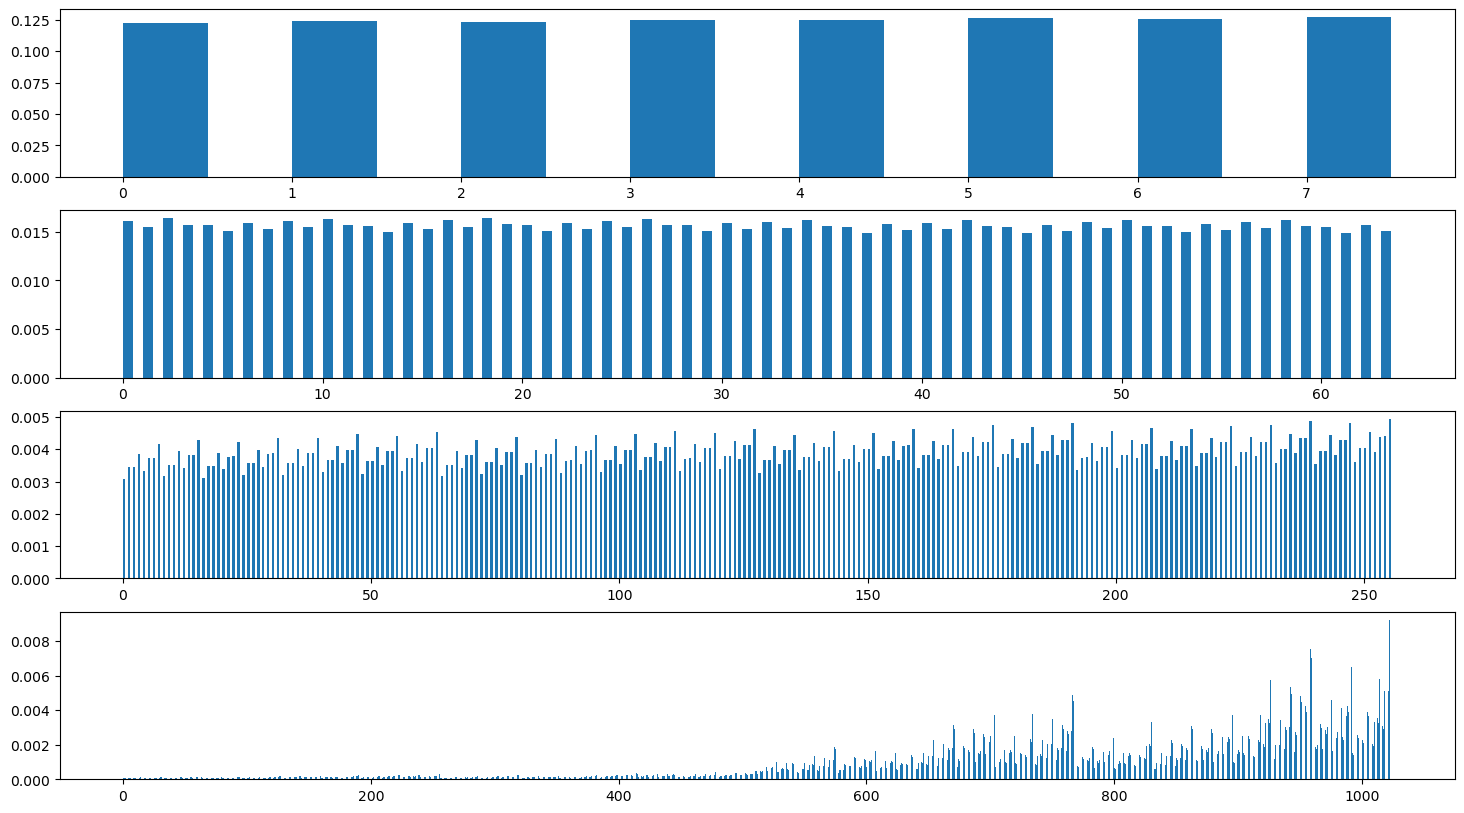

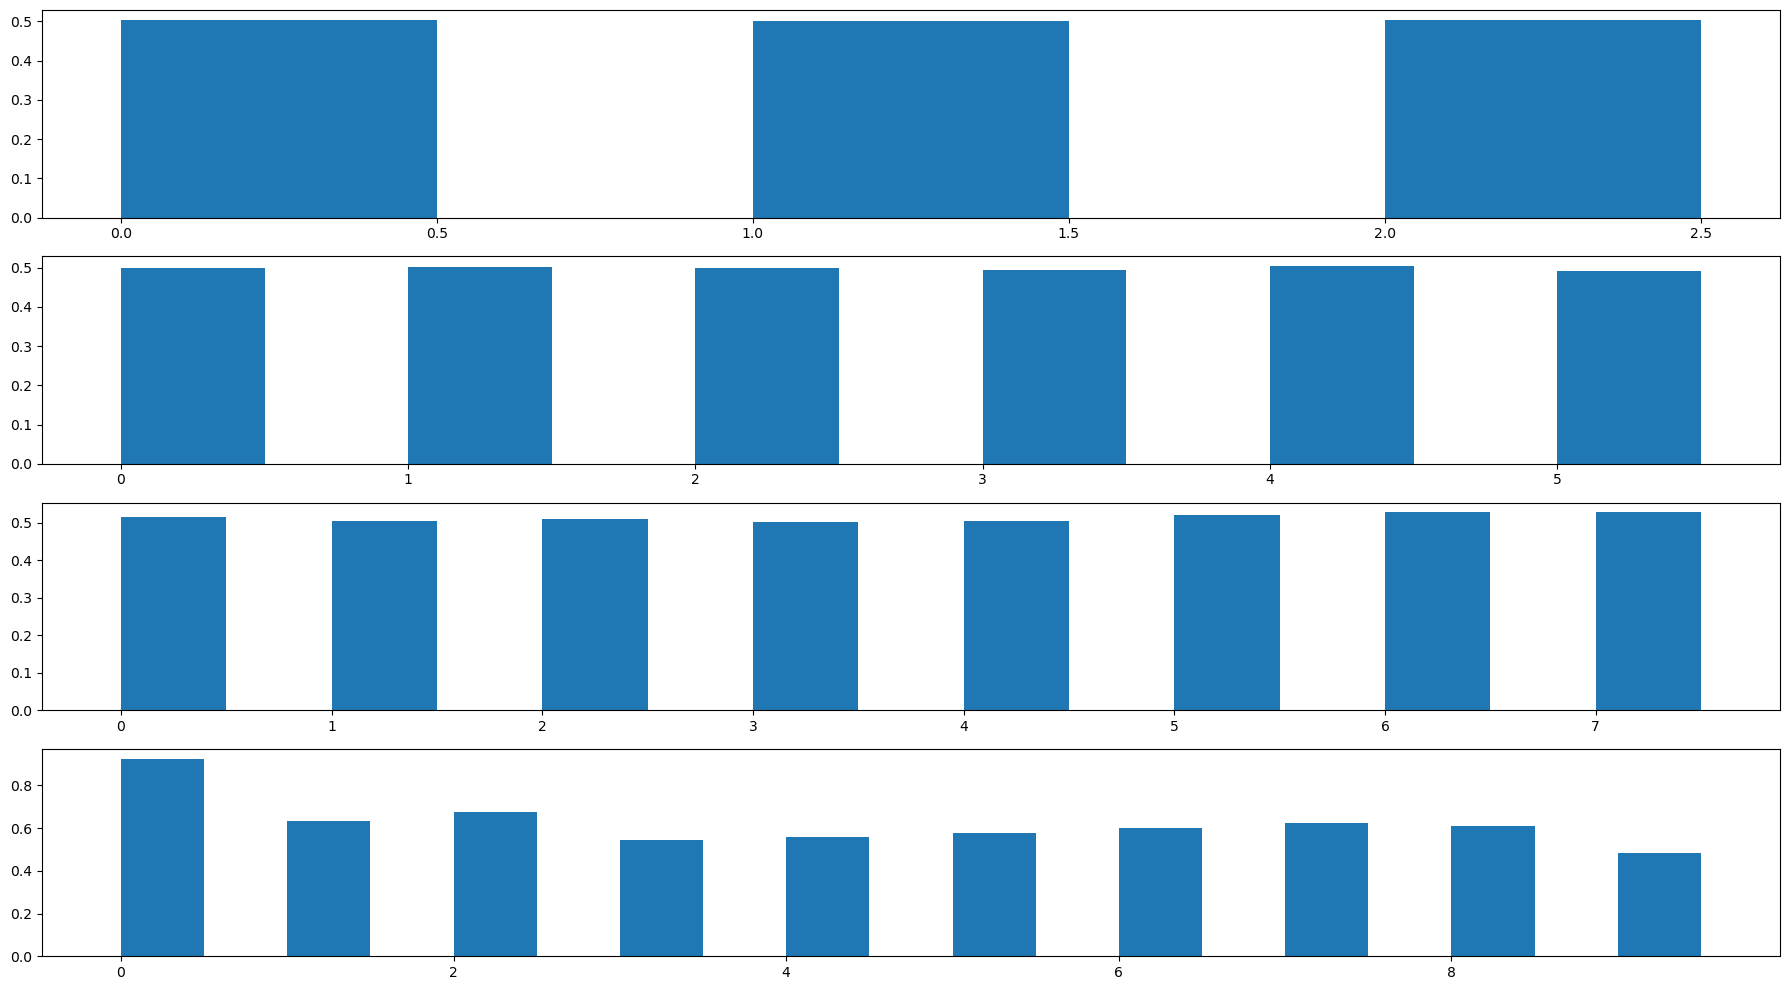

In [91]:
fig_ct, ax_ct = plt.subplots(n_layer-1, 1, figsize=(18, 10))
fig_ft, ax_ft = plt.subplots(n_layer-1, 1, figsize=(18, 10))
for i in range(n_layer-1):
    prob_ft, prob_ct = one_step_prob_matrix(n_dz[n_layer-1-i], Theta["Theta_" + str(n_layer-1-i) + str(n_layer-2-i)],dev)
    if i == 0:
        dist_ct = prob_ct
        dist_ft = prob_ft
        H_ct_YX = entropy(prob_ct)
        H_ft_YX = entropy_bernoulli(prob_ft)
    else:
        dist_ct = torch.matmul(dist_ct_pre,prob_ct)
        dist_ft = torch.matmul(dist_ct_pre,prob_ft)
        H_ct_YX = torch.matmul(dist_ct_pre,entropy(prob_ct))
        H_ft_YX = torch.matmul(dist_ct_pre,entropy_bernoulli(prob_ft))
    ax_ct[i].bar(np.arange(dist_ct.shape[1]),dist_ct.to('cpu').numpy().reshape(-1,),width=0.5,align='edge')
    ax_ft[i].bar(np.arange(dist_ft.shape[1]),dist_ft.to('cpu').numpy().reshape(-1,),width=0.5,align='edge')
    
    H_ct_Y = entropy(dist_ct)
    H_ft_Y = entropy_bernoulli(dist_ft)
    print('H_ct_Y:',H_ct_Y,'H_ft_Y:',H_ft_Y)
    print('H_ct_YX:',H_ct_YX,'H_ft_YX:',H_ft_YX)
    dist_ct_pre = dist_ct
    
plt.tight_layout()    
plt.show()

In [45]:
i= 0
one_step_prob_matrix(n_dz[n_layer-1-i], Theta["Theta_" + str(n_layer-1-i) + str(n_layer-2-i)],dev)

(tensor([[0.5039, 0.5016, 0.5029]]),
 tensor([[0.1229, 0.1244, 0.1237, 0.1252, 0.1248, 0.1263, 0.1256, 0.1271]]))

In [100]:
data_dcm = decimalize(well_formed_set,dev)
data_dcm

tensor([1023,  767,  895,  959,  703,  831,  991,  735,  863,  927,  671,  799,
        1007,  751,  879,  943,  687,  815,  975,  719,  847,  911,  655, 1015,
         759,  887,  951,  695,  823,  983,  727,  855,  919,  663,  791,  999,
         743,  871,  935,  679,  967,  711,  839, 1019,  763,  891,  955,  699,
         827,  987,  731,  859,  923,  667,  795, 1003,  747,  875,  939,  683,
         811,  971,  715,  843,  907,  651, 1011,  755,  883,  947,  691,  819,
         979,  723,  851,  995,  739,  867,  931,  675, 1021,  765,  893,  957,
         701,  829,  989,  733,  861,  925,  669,  797, 1005,  749,  877,  941,
         685,  813,  973,  717,  845,  909,  653, 1013,  757,  885,  949,  693,
         821,  981,  725,  853,  917,  661,  789,  997,  741,  869,  933,  677,
         965,  709,  837, 1022,  766,  894,  958,  702,  830,  990,  734,  862,
         926,  670,  798, 1006,  750,  878,  942,  686,  814,  974,  718,  846,
         910,  654, 1014,  758,  886,  9

In [103]:
values_d,counts_d = torch.unique(data_dcm,return_counts=True)
data_dist = torch.zeros(2**n_d)
data_dist[values_d]=counts_d/n_data
data_dist

tensor([0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0039])

In [ ]:
fig_ct, ax_ct = plt.subplots(n_layer-1, 1, figsize=(18, 10))
ax_ct.set_title("Layer-wise Categorical Distribution")
fig_ft, ax_ft = plt.subplots(n_layer-1, 1, figsize=(18, 10))
ax_ft.set_title("Layer-wise Fatorial Distribution")
dist_ct_pre_s = torch.ones(1,1,dtype=int,device=dev)
dist_ct_pre_w = data_dist
for i in range(n_layer-1):
    prob_ft_s, prob_ct_s = one_step_prob_matrix(n_dz[n_layer-1-i], Theta["Theta_" + str(n_layer-1-i) + str(n_layer-2-i)],dev)
    prob_ft_w, prob_ct_w = one_step_prob_matrix(n_dz[i], Phi["Phi_" + str(i) + str(i+1)],dev)
    
    dist_ct_s, H_ct_Y_s, H_ct_YX_s = prob_matrix_ct(dist_ct_pre_s, prob_ct_s)
    I_ct_s = H_ct_Y_s - H_ct_YX_s
    ax_ct[i].bar(np.arange(dist_ct.shape[1]),dist_ct_s.to('cpu').numpy().reshape(-1,),width=0.5,align='edge')
    ax_ct[i].set_title("Layer "+str(n_layer-1-i))
    ax_ct[i].legend()
    
    dist_ft_s, H_ft_Y_s, H_ft_YX_s = prob_matrix_ft(dist_ct_pre_s, prob_ft_s)
    ax_ft[i].bar(np.arange(dist_ft.shape[1]),dist_ft_s.to('cpu').numpy().reshape(-1,),width=0.5,align='edge')
    
    print('H_ct_Y_s:',H_ct_Y_s,'H_ft_Y_s:',H_ft_Y_s)
    print('H_ct_YX_s:',H_ct_YX_s,'H_ft_YX_s:',H_ft_YX_s)
    dist_ct_pre_s = dist_ct_s
    
plt.tight_layout()    
plt.show()

In [ ]:
dist_ct, H_ct_Y, H_ct_YX = prob_matrix_ct(dist_ct_pre, prob_ct)

In [ ]:
dist_ft, H_ft_Y, H_ft_YX = prob_matrix_ft(dist_ct_pre, prob_ft)